# 정리 방법
- 키워드 정리
- 도표/그림 정리
- 코드 분석

In [1]:
# 2-1 데이터셋 적재
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
# 2-2 신경망 구조
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [4]:
# 2-3 컴파일 단계
model.compile(optimizer="rmsprop",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
# 2-4 이미지 데이터 준비
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

In [7]:
# 2-5 모델 훈련
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 7s 13ms/step - loss: 0.2652 - accuracy: 0.9239
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1090 - accuracy: 0.9682
Epoch 3/5
469/469 [==============================] - 5s 11ms/step - loss: 0.0716 - accuracy: 0.9784
Epoch 4/5
469/469 [==============================] - 6s 13ms/step - loss: 0.0523 - accuracy: 0.9848
Epoch 5/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0392 - accuracy: 0.9883


In [8]:
# 2-6 예측
test_digits = test_images[0:10]
predictions = model.predict(test_digits)
predictions[0]

1/1 [==============================] - 0s 85ms/step


array([2.6204899e-07, 3.3658139e-08, 1.0253798e-05, 5.4090540e-04,
       2.1953774e-10, 3.9391293e-07, 6.2410173e-12, 9.9941957e-01,
       1.1466631e-06, 2.7319846e-05], dtype=float32)

In [13]:
for i in range(10):
  print('{}: {}'.format(i, predictions[i].argmax() == test_labels[i]))


0: True
1: True
2: True
3: True
4: True
5: True
6: True
7: True
8: True
9: True


In [14]:
# 2-7 테스트 데이터 평가
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"테스트 정확도: {test_acc}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0638 - accuracy: 0.9803
테스트 정확도: 0.9803000092506409


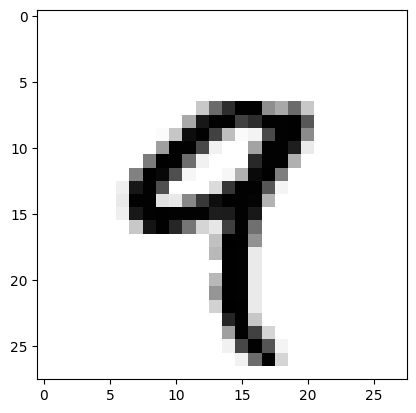

In [19]:
# 2-8
import numpy as np
import matplotlib.pyplot as plt

digit = np.reshape(train_images[4],(28, 28))
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [21]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]


class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

learning_rate = 1e-3

from tensorflow.keras import optimizers
optimizer = optimizers.SGD(learning_rate = 1e-3)
def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"에포크 {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"{batch_counter}번째 배치 손실: {loss:.2f}")

from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)



에포크 0
0번째 배치 손실: 5.41
100번째 배치 손실: 2.27
200번째 배치 손실: 2.26
300번째 배치 손실: 2.10
400번째 배치 손실: 2.25
에포크 1
0번째 배치 손실: 1.95
100번째 배치 손실: 1.91
200번째 배치 손실: 1.88
300번째 배치 손실: 1.73
400번째 배치 손실: 1.86
에포크 2
0번째 배치 손실: 1.62
100번째 배치 손실: 1.61
200번째 배치 손실: 1.55
300번째 배치 손실: 1.45
400번째 배치 손실: 1.53
에포크 3
0번째 배치 손실: 1.36
100번째 배치 손실: 1.36
200번째 배치 손실: 1.28
300번째 배치 손실: 1.23
400번째 배치 손실: 1.29
에포크 4
0번째 배치 손실: 1.15
100번째 배치 손실: 1.17
200번째 배치 손실: 1.07
300번째 배치 손실: 1.06
400번째 배치 손실: 1.12
에포크 5
0번째 배치 손실: 1.00
100번째 배치 손실: 1.03
200번째 배치 손실: 0.92
300번째 배치 손실: 0.94
400번째 배치 손실: 1.00
에포크 6
0번째 배치 손실: 0.89
100번째 배치 손실: 0.92
200번째 배치 손실: 0.81
300번째 배치 손실: 0.85
400번째 배치 손실: 0.91
에포크 7
0번째 배치 손실: 0.80
100번째 배치 손실: 0.83
200번째 배치 손실: 0.73
300번째 배치 손실: 0.78
400번째 배치 손실: 0.84
에포크 8
0번째 배치 손실: 0.74
100번째 배치 손실: 0.76
200번째 배치 손실: 0.67
300번째 배치 손실: 0.72
400번째 배치 손실: 0.78
에포크 9
0번째 배치 손실: 0.69
100번째 배치 손실: 0.71
200번째 배치 손실: 0.62
300번째 배치 손실: 0.67
400번째 배치 손실: 0.74
